In [76]:
from bs4 import BeautifulSoup
import requests
import math
import pandas as pd
import patsy

import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression,Ridge, Lasso, LassoCV ,RidgeCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import PolynomialFeatures,StandardScaler
from sklearn.pipeline import make_pipeline

import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [3]:
import warnings 
warnings.filterwarnings("ignore")
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

### Acquiring data 

Sources we acquired from are www.sa.aqar.fm and www.propertyfinder.sa

In [ ]:
villas=[]
widths1=[]
i=1

while i<100:
    url = f"https://sa.aqar.fm/%D9%81%D9%84%D9%84-%D9%84%D9%84%D8%A8%D9%8A%D8%B9/{i}"
    res=requests.get(url)
    if res.status_code==200:
        p=res.text
        soup=BeautifulSoup(p,"lxml")
        i+=1
        
        houses=soup.find_all("div", {"class":"titleAndDetails"})
        headers = ["Price", "#Bedrooms", "#Bathrooms", "Size(m²)","District"]
        for house in houses:
            price = float(house.find(class_="price").text.replace("ريال", "").replace(",", "").strip())
            bed = int(house.find(class_="bed").text.strip())
            bath = int(house.find(class_="bath").text.strip())
            size = float(house.find(class_="size").text.replace("م²", "").strip())
            districts = house.find(class_="locText").text.strip()
            house_dict = dict(zip(headers, [price, bed, bath, size, districts]))
            villas.append(house_dict)
            
        URL= soup.find_all("a",class_="listTitle")
        for h in URL:
            pageurl="https://sa.aqar.fm"+h["href"]
            resp=requests.get(pageurl)
            hpage= resp.text
            hsoup=BeautifulSoup(hpage, "lxml")
            table=hsoup.find("table",class_="dc-detailsTable")
            rows=table.find_all("tr")
            
            for row in rows:
                if "الشارع" in row.text:
                    x=int(row.find_all("td")[0].text.replace("م", "").strip())
                    widths1.append(x)
    else:
        break

In [ ]:
len(villas)

In [ ]:
len(widths1)

In [ ]:
from statistics import mean

ele=1

while ele<(len(villas)-len(widths1)+ele):
    widths1.append(int(mean(widths1)))
    ele+=1

In [ ]:
len(widths1)

In [ ]:
villaDF=pd.DataFrame(villas)

In [ ]:
villaDF["StreetWidth"]=widths1

In [ ]:
villaDF

In [ ]:
villaDF= villaDF[villaDF.District.str.contains("الرياض") == True]
villaDF

In [ ]:
villaDF= villaDF[villaDF.District.str.contains("حي الرياض - جدة") == False]
villaDF.head()

In [ ]:
villaDF.describe()

In [ ]:
villaDF.shape

In [ ]:
villaDF.to_excel("villas.xlsx")

In [ ]:
houses_list = []
widths=[]

i = 1
while i < 200:
    url = f"https://sa.aqar.fm/%D8%A8%D9%8A%D8%AA-%D9%84%D9%84%D8%A8%D9%8A%D8%B9/%D8%A7%D9%84%D8%B1%D9%8A%D8%A7%D8%B6/{i}" 
    response = requests.get(url)
    if response.status_code == 200:
        page = response.text
        soup = BeautifulSoup(page, "lxml")
        i += 1
        houses=soup.find_all("div", {"class":"titleAndDetails"})
        headers = ["Price", "#Bedrooms", "#Bathrooms", "Size(m²)","District"]
        for house in houses:
            price = float(house.find(class_="price").text.replace("ريال", "").replace(",", "").strip())
            bed = int(house.find(class_="bed").text.strip())
            bath = int(house.find(class_="bath").text.strip())
            size = float(house.find(class_="size").text.replace("م²", "").strip())
            districts = house.find(class_="locText").text.strip()
            house_dict = dict(zip(headers, [price, bed, bath, size, districts]))
            houses_list.append(house_dict)
            
        URL= soup.find_all("a",class_="listTitle")
        for h in URL:
            pageurl="https://sa.aqar.fm"+h["href"]
            resp=requests.get(pageurl)
            hpage= resp.text
            hsoup=BeautifulSoup(hpage, "lxml")
            table=hsoup.find("table",class_="dc-detailsTable")
            rows=table.find_all("tr")
            
            for row in rows:
                if "الشارع" in row.text:
                    x=int(row.find_all("td")[0].text.replace("م", "").strip())
                    widths.append(x)
    else:
        break

In [ ]:
len(houses_list)

In [ ]:
len(widths)

In [ ]:

e=1

while e < (len(houses_list)-len(widths)+e):
    widths.append(int(mean(widths)))
    e+=1

In [ ]:
len(widths)

In [ ]:
df = pd.DataFrame(houses_list)
df.head()

In [ ]:
df.describe()

In [ ]:
df["StreetWidth"]=widths
df

In [ ]:
houses_list2 = []
i = 1
while i < 56:
    url_2 = f"https://www.propertyfinder.sa/ar/search?bf=1&btf=1&c=1&l=4&ob=mr&page={i}&pf=400000&t=35" 
    response2 = requests.get(url_2)
    if response2.status_code == 200:
        page2 = response2.text
        soup2 = BeautifulSoup(page2, "lxml")
        i += 1
        houses2=soup2.find_all("div", {"class":"card-list__item"})
        headers2 = ["Price", "#Bedrooms", "#Bathrooms", "Size(m²)","District"]
        for house in houses2:
            price = float(house.find(class_="card__price-value").text.replace("ريال", "").replace(",", "").strip())
            bed = house.find(class_="card__property-amenity card__property-amenity--bedrooms").text.replace("+", "").replace("عدد الغرف","").strip()
            bath = house.find(class_="card__property-amenity card__property-amenity--bathrooms").text.replace("+", "").replace("حمامات","").strip()
            size = float(house.find(class_="card__property-amenity card__property-amenity--area").text.replace("متر مربع", "").replace(",", "").strip())
            districts = house.find(class_="card__location-text").text.replace("حي الملقا","الملقا").strip()
            house_dict = dict(zip(headers, [price, bed, bath, size, districts]))
            houses_list2.append(house_dict)
    else:
        break

In [ ]:
len(houses_list2)

In [ ]:
df2 = pd.DataFrame(houses_list2)
df2.describe()

In [ ]:
#df3 = pd.concat([df, df2,villaDF]) #All sites
#df3 = pd.concat([df2,villaDF]) # Only Villas from AQAR & Property Finder
#df3 = pd.concat([villaDF]) # Only Villas from AQAR
df3 = pd.concat([df, villaDF]) # Villas and Houses from AQAR (both links)

df3

### Data Pre Processing 
(EDA, Cleaning)

In [ ]:
df3.isna().sum()

In [ ]:
df3["StreetWidth"].fillna(df3["StreetWidth"].median(), inplace = True)

In [ ]:
df3.isna().sum()

In [ ]:
df3["StreetWidth"].isna().sum()

In [ ]:
df3.head()

In [ ]:
df3['District'] = df3['District'].str.split(" - ", n = 1, expand = True)
df3

In [ ]:
df3['District'] = df3['District'].str.split(", ", n = 1, expand = True)
df3

In [ ]:
df3['District'] = df3['District'].str.replace("حي ", "")
df3

In [ ]:
df3.to_excel("aqar.xlsx")

In [4]:
df3= pd.read_excel ('aqar.xlsx')

In [5]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5504 entries, 0 to 5503
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   5504 non-null   int64 
 1   Price        5504 non-null   int64 
 2   #Bedrooms    5504 non-null   int64 
 3   #Bathrooms   5504 non-null   int64 
 4   Size(m²)     5504 non-null   int64 
 5   District     5504 non-null   object
 6   StreetWidth  5504 non-null   int64 
dtypes: int64(6), object(1)
memory usage: 301.1+ KB


In [6]:
df3.shape

(5504, 7)

In [7]:
df3.sample(4)

,Unnamed: 0,Price,#Bedrooms,#Bathrooms,Size(m²),District,StreetWidth
5211,1594,1140000,5,5,250,طويق,20
3252,3252,250000,5,4,115,منفوحة,5
4609,820,1500000,6,4,365,الشرق,15
1788,1788,200000,5,1,90,الجرادية,5


In [8]:
df3.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [9]:
df3['#Bedrooms'] = df3['#Bedrooms'].astype(float, errors = 'raise')
df3['#Bathrooms'] = df3['#Bathrooms'].astype(float, errors = 'raise')
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5504 entries, 0 to 5503
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Price        5504 non-null   int64  
 1   #Bedrooms    5504 non-null   float64
 2   #Bathrooms   5504 non-null   float64
 3   Size(m²)     5504 non-null   int64  
 4   District     5504 non-null   object 
 5   StreetWidth  5504 non-null   int64  
dtypes: float64(2), int64(3), object(1)
memory usage: 258.1+ KB


In [10]:
df3['District'].value_counts().head(10)

طويق              875
النظيم            321
السويدي           220
منفوحة الجديدة    213
الرمال            187
ظهرة لبن          165
الصالحية          151
الجرادية          130
الدار البيضاء     117
أحد               109
Name: District, dtype: int64

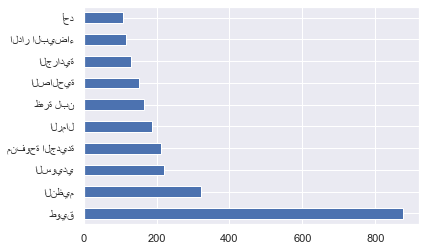

In [11]:
df3['District'].value_counts()[:10].plot(kind='barh');

In [12]:
top_Dis =df3[['District' ,'Price']].groupby('District').mean().reset_index().sort_values(by = 'Price', ascending = False)
top_Dis.head(10)

,District,Price
42,الغدير,1.000000e+07
92,حطين,7.883333e+06
71,النزهة,6.000000e+06
52,المحمدية,6.000000e+06
61,الملقا,5.882836e+06
69,النخيل,5.716667e+06
68,الناصرية,5.000000e+06
40,العليا,4.600000e+06
107,قرطبة,4.273214e+06
58,المعذر الشمالي,4.150000e+06


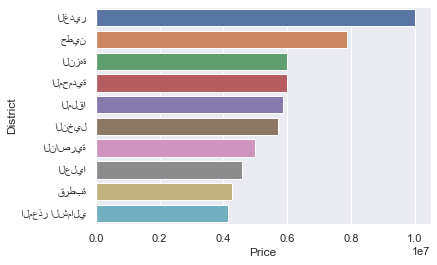

In [13]:
sns.barplot(data=top_Dis.head(10), x='Price',y='District', palette = 'deep');

Skewness: 5.267729
Kurtosis: 69.671025


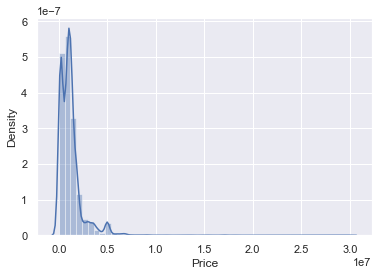

In [14]:
sns.distplot(df3['Price']);
#skewness and kurtosis
print("Skewness: %f" % df3['Price'].skew())
print("Kurtosis: %f" % df3['Price'].kurt())

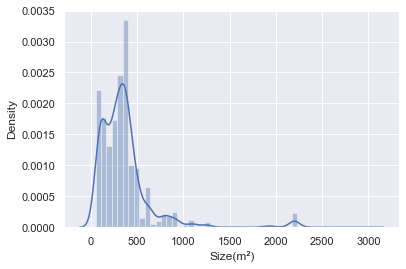

In [15]:
sns.distplot(df3['Size(m²)']);

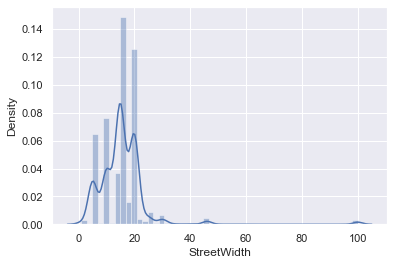

In [16]:
sns.distplot(df3['StreetWidth']);

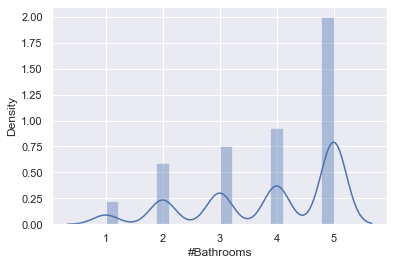

In [17]:
sns.distplot(df3['#Bathrooms']);

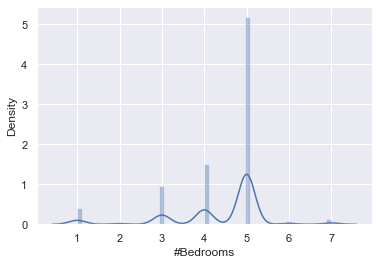

In [18]:
sns.distplot(df3['#Bedrooms']);

In [19]:
df3.describe()

,Price,#Bedrooms,#Bathrooms,Size(m²),StreetWidth
count,5.504000e+03,5504.000000,5504.000000,5504.000000,5504.000000
mean,1.193790e+06,4.414608,3.863009,363.307776,15.480923
std,1.276224e+06,1.108494,1.251908,318.800361,9.261991
min,9.000000e+02,1.000000,1.000000,50.000000,1.000000
25%,3.000000e+05,4.000000,3.000000,183.000000,10.000000
50%,1.050000e+06,5.000000,4.000000,307.000000,15.000000
75%,1.400000e+06,5.000000,5.000000,400.000000,20.000000
max,3.000000e+07,7.000000,5.000000,3000.000000,100.000000


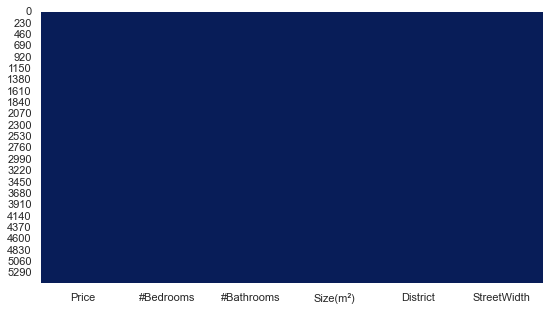

In [20]:
fig, ax = plt.subplots(figsize=(9,5))
sns.heatmap(df3.isnull(), cbar=False, cmap="YlGnBu_r")#check if there is any null values
plt.show()

Insight: No nulls

In [21]:
df3.corr()

,Price,#Bedrooms,#Bathrooms,Size(m²),StreetWidth
Price,1.000000,0.197929,0.381359,0.665997,0.069255
#Bedrooms,0.197929,1.000000,0.532248,0.188957,0.032152
#Bathrooms,0.381359,0.532248,1.000000,0.354889,0.071348
Size(m²),0.665997,0.188957,0.354889,1.000000,0.011889
StreetWidth,0.069255,0.032152,0.071348,0.011889,1.000000


In [22]:
df3.cov()

,Price,#Bedrooms,#Bathrooms,Size(m²),StreetWidth
Price,1.628749e+12,280008.301436,609303.240611,2.709682e+08,818622.111800
#Bedrooms,2.800083e+05,1.228760,0.738618,6.677533e+01,0.330099
#Bathrooms,6.093032e+05,0.738618,1.567274,1.416395e+02,0.827297
Size(m²),2.709682e+08,66.775333,141.639481,1.016337e+05,35.105273
StreetWidth,8.186221e+05,0.330099,0.827297,3.510527e+01,85.784481


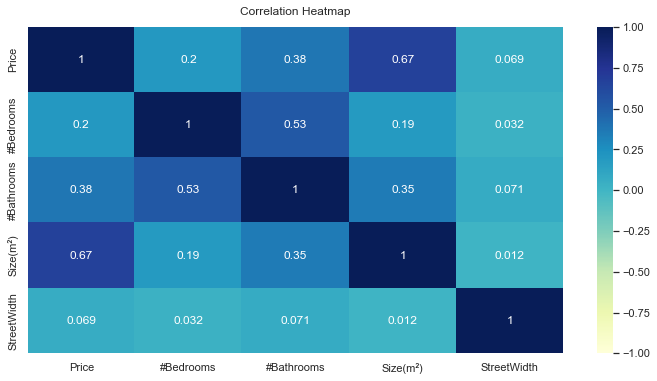

In [23]:
plt.figure(figsize=(12, 6))
heatmap = sns.heatmap(df3.corr(), vmin=-1, vmax=1, annot=True,cmap="YlGnBu")
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);
plt.show()

- The "Size" feature has high positive correlation 0.61 with our target "Price"
- The "Bathrooms" feature has positive correlation 0.33 with our target "Price"
- The "Bedrooms" feature has low positive correlation 0.18 with our target "Price"

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


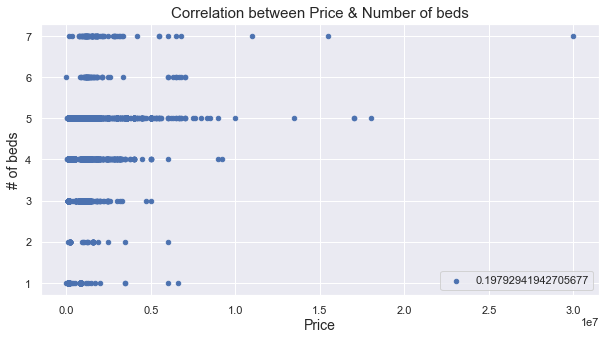

In [24]:
corr = df3["Price"].corr(df3['#Bedrooms']) 
df3.plot(kind="scatter",y="#Bedrooms" , x="Price",figsize=(10,5) , label = corr)
plt.title("Correlation between Price & Number of beds" , fontsize=15)
plt.xlabel("Price" , fontsize=14)
plt.ylabel("# of beds" , fontsize=14)
plt.legend();

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


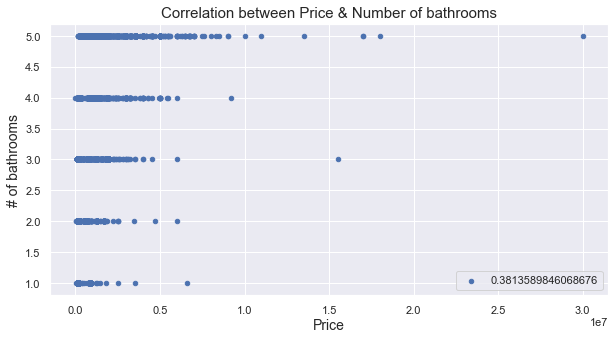

In [25]:
corr = df3['Price'].corr(df3['#Bathrooms']) 
df3.plot(kind="scatter",y="#Bathrooms" , x="Price",figsize=(10,5) , label = corr)
plt.title("Correlation between Price & Number of bathrooms" , fontsize=15)
plt.xlabel("Price" , fontsize=14)
plt.ylabel("# of bathrooms" , fontsize=14)
plt.legend();

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


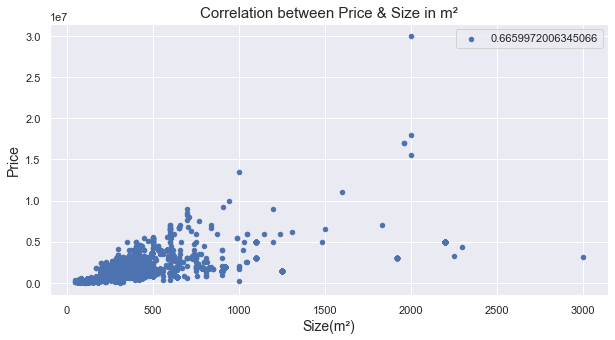

In [26]:
corr = df3['Price'].corr(df3['Size(m²)']) 
df3.plot(kind="scatter",y="Price" , x="Size(m²)",figsize=(10,5) , label = corr)
plt.title("Correlation between Price & Size in m²" , fontsize=15)
plt.xlabel("Size(m²)" , fontsize=14)
plt.ylabel("Price" , fontsize=14)
plt.legend();

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
No handles with labels found to put in legend.


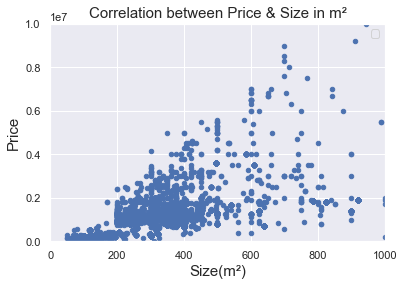

In [27]:
#Zoomed in plot for the price vs size(m2)

df3.plot(x="Size(m²)", y='Price', kind='scatter')
plt.xlim([0, 1000])
plt.ylim([0,1e7])
plt.title("Correlation between Price & Size in m²" , fontsize=15)
plt.xlabel("Size(m²)" , fontsize=15)
plt.ylabel("Price" , fontsize=15)
plt.legend();

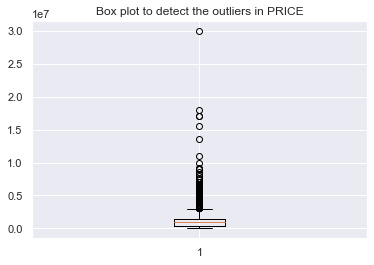

In [28]:
plt.boxplot(df3["Price"])
plt.title("Box plot to detect the outliers in PRICE")
plt.show()

In [29]:
df3.Price.describe()

count    5.504000e+03
mean     1.193790e+06
std      1.276224e+06
min      9.000000e+02
25%      3.000000e+05
50%      1.050000e+06
75%      1.400000e+06
max      3.000000e+07
Name: Price, dtype: float64

In [30]:
def outlier_treatment(datacolumn):
    sorted(datacolumn)
    Q1,Q3 = np.percentile(datacolumn , [25,75])
    IQR = Q3 - Q1
    lower_range = Q1 - (1.5 * IQR)
    upper_range = Q3 + (1.5 * IQR)
    return lower_range,upper_range

In [31]:
Q1,Q3 = np.percentile(df3.Price, [25,75])
IQR = Q3 - Q1
lower_range = Q1 - (1.5 * IQR)
upper_range = Q3 + (1.5 * IQR)
#df3.Price.apply(outlier_treatment)
Q1,Q3,IQR,lower_range,upper_range

(300000.0, 1400000.0, 1100000.0, -1350000.0, 3050000.0)

Text(0.5, 1.0, 'before remove outliers')

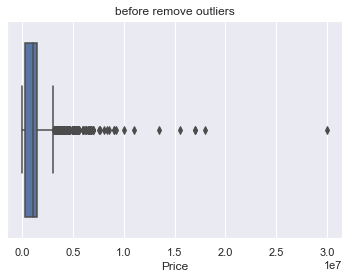

In [32]:
sns.boxplot(x=df3["Price"])
plt.title("before remove outliers")

In [33]:
df4 = df3.copy()
#mask_df4= (df4["Price"] > 0.5e6) & (df4["Price"] < 5e6)
mask_df4= (df4["Price"] > 0.5e6)

df4 = df4[mask_df4]
df4.Price.describe()

count    3.896000e+03
mean     1.599861e+06
std      1.316561e+06
min      5.100000e+05
25%      9.500000e+05
50%      1.250000e+06
75%      1.800000e+06
max      3.000000e+07
Name: Price, dtype: float64

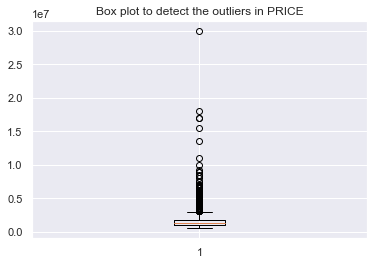

In [34]:
plt.boxplot(df4["Price"])
plt.title("Box plot to detect the outliers in PRICE")
plt.show()

In [35]:
df4[df4.index.duplicated()]

,Price,#Bedrooms,#Bathrooms,Size(m²),District,StreetWidth


In [36]:
df4.columns.duplicated().any()

False

In [37]:
df4= df4.loc[~df4.index.duplicated(), :]

In [38]:
df4.shape

(3896, 6)

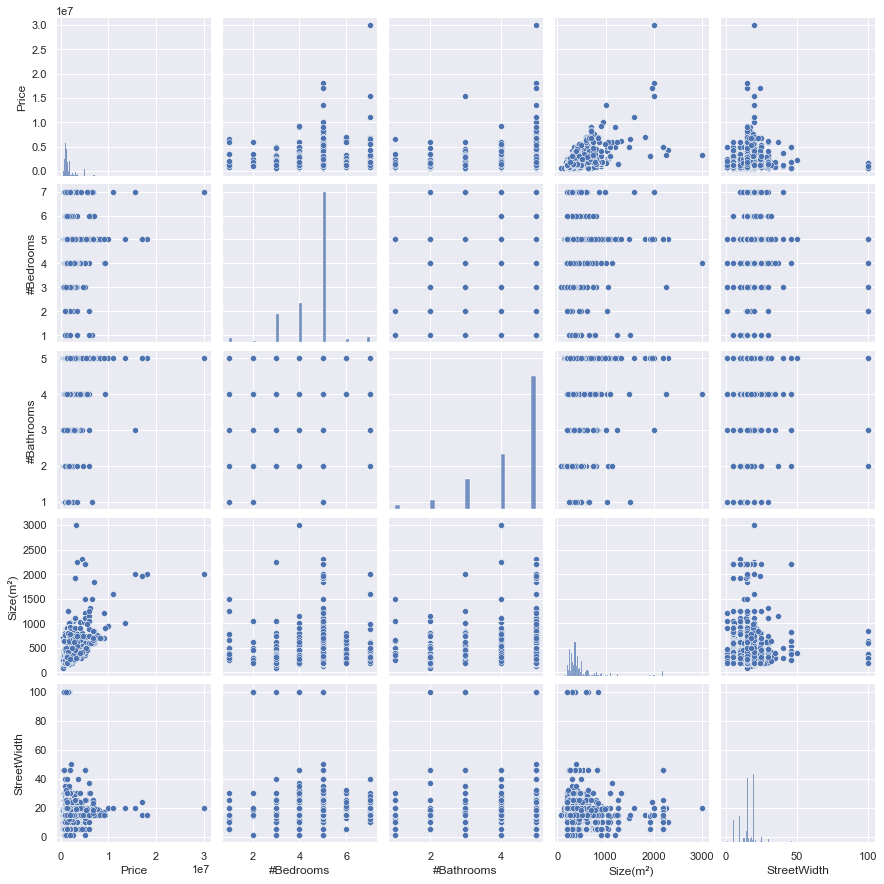

In [39]:
sns.pairplot(df4);

**Make a copy of dataframe**

In [40]:
DF=df4.copy()

Encode the District feature to be able to feed the model

In [41]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
DF['District'] = labelencoder.fit_transform(DF['District'])

In [42]:
DF.head()

,Price,#Bedrooms,#Bathrooms,Size(m²),District,StreetWidth
1,800000,5.0,3.0,240,84,20
2,1100000,5.0,5.0,375,84,15
3,5000000,5.0,5.0,2200,60,5
5,3600000,5.0,5.0,495,28,15
6,1450000,5.0,4.0,480,84,10


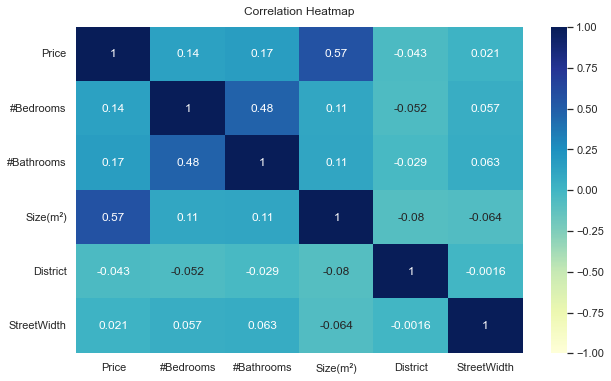

In [43]:
plt.figure(figsize=(10, 6))
heatmap = sns.heatmap(DF.corr(), vmin=-1, vmax=1, annot=True,cmap="YlGnBu")
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);
plt.show()

**Trying to add log function to enhance the correlations between Price and other features: Street width, bedrooms, bathrooms**

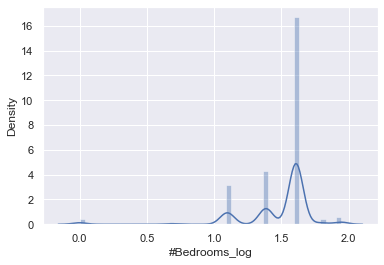

In [44]:
DF['#Bedrooms_log'] = np.log(DF['#Bedrooms'])
sns.distplot(DF['#Bedrooms_log']);

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


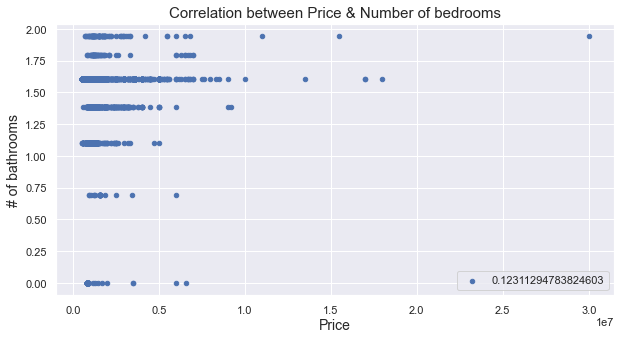

In [45]:
corr = DF['Price'].corr(DF['#Bedrooms_log']) 
DF.plot(kind="scatter",y="#Bedrooms_log" , x="Price",figsize=(10,5) , label = corr)
plt.title("Correlation between Price & Number of bedrooms" , fontsize=15)
plt.xlabel("Price" , fontsize=14)
plt.ylabel("# of bathrooms" , fontsize=14)
plt.legend();

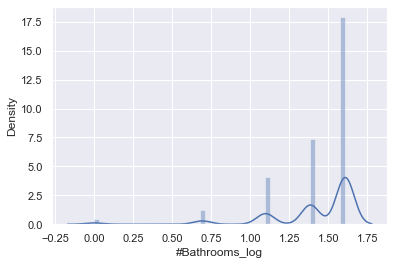

In [46]:
DF['#Bathrooms_log'] = np.log(DF['#Bathrooms'])
sns.distplot(DF['#Bathrooms_log']);

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


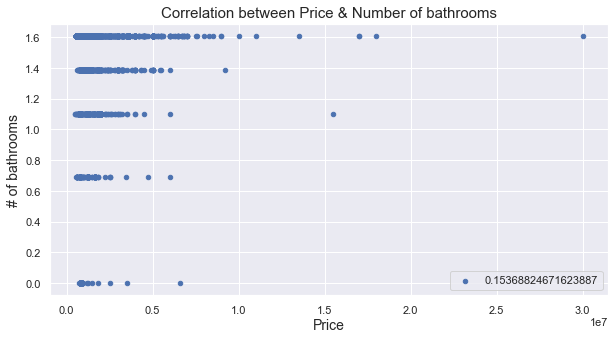

In [47]:
corr = DF['Price'].corr(DF['#Bathrooms_log']) 
DF.plot(kind="scatter",y="#Bathrooms_log" , x="Price",figsize=(10,5) , label = corr)
plt.title("Correlation between Price & Number of bathrooms" , fontsize=15)
plt.xlabel("Price" , fontsize=14)
plt.ylabel("# of bathrooms" , fontsize=14)
plt.legend();

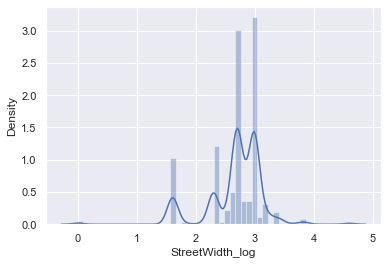

In [48]:
DF['StreetWidth_log'] = np.log(DF['StreetWidth'])
sns.distplot(DF['StreetWidth_log']);

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


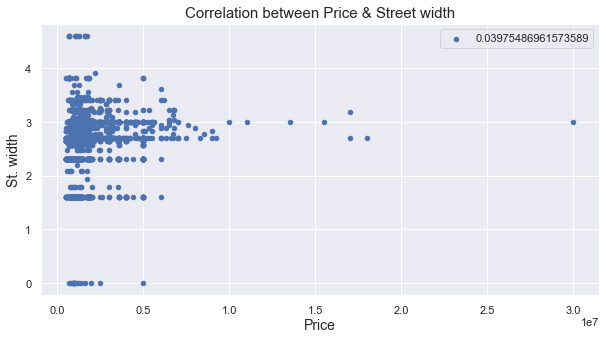

In [49]:
corr = DF['Price'].corr(DF['StreetWidth_log']) 
DF.plot(kind="scatter",y="StreetWidth_log" , x="Price",figsize=(10,5) , label = corr)
plt.title("Correlation between Price & Street width" , fontsize=15)
plt.xlabel("Price" , fontsize=14)
plt.ylabel("St. width" , fontsize=14)
plt.legend();

**Result:**
- There is not much improvement except for the "StreetWidth"; the correlation improved slightly, the rest of features had better correlation with Price before performing log()

### Modeling

In [50]:
X_train, X_test, y_train, y_test = train_test_split(DF[['Size(m²)']], DF[['Price']], 
                                                    test_size=0.3, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

In [51]:
print("Training Data has",X_train.shape)
print("Testing Data has",X_test.shape)
print("Validation Data has",X_val.shape)

Training Data has (1908, 1)
Testing Data has (1169, 1)
Validation Data has (819, 1)


In [52]:
list_models=[]
list_scores=[]
list_errors=[]
lr=LinearRegression()
lr.fit(X_train,y_train)
pred_1=lr.predict(X_val)
score_1=r2_score(y_val,pred_1)
error_1=mean_squared_error(y_val,pred_1)
list_models.append('linear regression')
list_scores.append(score_1)
list_errors.append(error_1)
print("Training accuracy: ",r2_score(y_train,lr.predict(X_train)))
print("Training error: ",1-r2_score(y_train,lr.predict(X_train)))
print("Testing accuracy: ",r2_score(y_val,lr.predict(X_val)))
print("Testing error: ",1-r2_score(y_val,lr.predict(X_val)))

Training accuracy:  0.314081061954979
Training error:  0.685918938045021
Testing accuracy:  0.36210818779196774
Testing error:  0.6378918122080323


In [53]:
lr.coef_

array([[2200.97255662]])

In [54]:
lr.intercept_

array([606688.36539159])

In [55]:
error_1*100

118417760072745.84

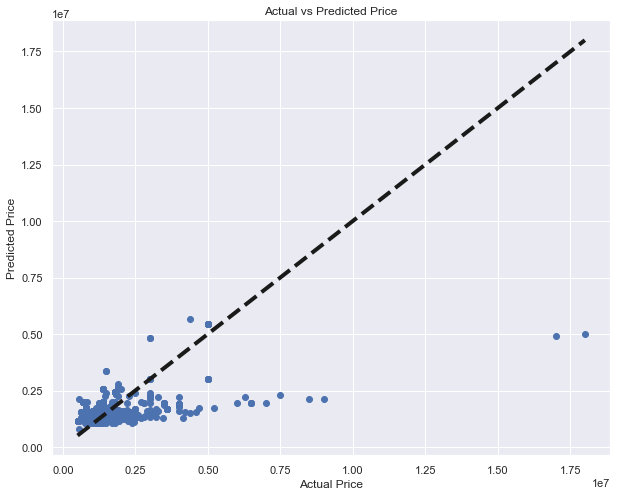

In [56]:
fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(y_val, pred_1)
ax.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=4)
ax.set_title('Actual vs Predicted Price')
ax.set_xlabel('Actual Price')
ax.set_ylabel('Predicted Price')
plt.show()

In [58]:
# fit model with target as housing price index
import statsmodels.api as sm

_model = sm.OLS(y_train, X_train, data=DF)

results =_model.fit()

# summarize our model
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  Price   R-squared (uncentered):                   0.706
Model:                            OLS   Adj. R-squared (uncentered):              0.706
Method:                 Least Squares   F-statistic:                              4590.
Date:                Tue, 12 Oct 2021   Prob (F-statistic):                        0.00
Time:                        01:14:22   Log-Likelihood:                         -29274.
No. Observations:                1908   AIC:                                  5.855e+04
Df Residuals:                    1907   BIC:                                  5.855e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Size(m²)    3082.5570     45.499     67.750      0.000    2993.323    3171.791
==============================================================================
Omnibus:                     1082.295   Durbin-Watson:                   1.881
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            20899.724
Skew:                           2.256   Prob(JB):                         0.00
Kurtosis:                      18.573   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [67]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(DF[['Size(m²)','#Bathrooms','#Bedrooms',"StreetWidth_log"]], DF[['Price']], 
                                                    test_size=0.3, random_state=42)

X_train1, X_val1, y_train1, y_val1 = train_test_split(X_train1, y_train1, test_size=0.3, random_state=42)

In [68]:
from sklearn.model_selection import cross_val_score
lm = LinearRegression()
scores = cross_val_score(lm, X_train1, y_train1, scoring='r2', cv=5)
scores.mean()

0.2938184067865051

In [69]:
print("Training Data has",X_train1.shape)
print("Testing Data has",X_test1.shape)
print("Validation Data has",X_val1.shape)

Training Data has (1908, 4)
Testing Data has (1169, 4)
Validation Data has (819, 4)


In [71]:
from sklearn.ensemble import RandomForestRegressor
rfg=RandomForestRegressor()
rfg.fit(X_train1,y_train1)
pred_2=rfg.predict(X_val1)
score_2=r2_score(y_val1,pred_2)
error_2=mean_squared_error(y_val1,pred_2)
list_models.append('randomforest')
list_scores.append(score_2)
list_errors.append(error_2)
print("Training accuracy: ",r2_score(y_train1,rfg.predict(X_train1)) )
print("Training error: ",1-r2_score(y_train1,rfg.predict(X_train1)) )
print("Testing accuracy: ",r2_score(y_val1,rfg.predict(X_val1)) )
print("Testing error: ",1-r2_score(y_val1,rfg.predict(X_val1)) )

Training accuracy:  0.9037963656424071
Training error:  0.09620363435759294
Testing accuracy:  0.6837990584969136
Testing error:  0.3162009415030864


In [72]:
#Before Feature selection 
lm.fit(X_train1,y_train1)
pred_1=lm.predict(X_test1)
score_1=r2_score(y_test1,pred_1)
error_1=mean_squared_error(y_test1,pred_1)
list_models.append('linear regression')
list_scores.append(score_1)
list_errors.append(error_1)
print("training accuracy: ",r2_score(y_train1,lm.predict(X_train1)) )
print("training error: ",1-r2_score(y_train1,lm.predict(X_train1)) )
print("testing accuracy: ",r2_score(y_test1,lm.predict(X_test1)) )
print("testing error: ",1-r2_score(y_test1,lm.predict(X_test1)) )

training accuracy:  0.33250376879502697
training error:  0.667496231204973
testing accuracy:  0.3279377481355382
testing error:  0.6720622518644618


In [79]:
def lasso_model(X_train,y_train,X_val,y_val, regular_var = 1,
                CV_flag = False, cv_value = 5, alphavec = [0.1,0.01, 0.001]):
    
    if CV_flag is True:
        m = LassoCV(alphas = alphavec, cv = cv_value)
        m.fit(X_train, y_train)
        print("mean error:", m.mse_path_)
    else:
        m = Lasso(alpha = regular_var) 
        m.fit(X_train, y_train )

        print("Training score :", round(m.score(X_train,y_train) ,5))
        print("Val score :", round(m.score(X_val,y_val),5))
    return m

In [82]:
lasso = lasso_model(X_train1
                   ,y_train1
                   ,X_val1
                   ,y_val1
                    ,regular_var = 100)

Training score : 0.3325
Val score : 0.38407


In [85]:
from sklearn.preprocessing import MinMaxScaler
target_scaler = MinMaxScaler()
target_scaler.fit(y_train1)


X2_train = X_train1.copy()
X2_val = X_val1.copy()

y2_train = target_scaler.transform(y_train1)
y2_val = target_scaler.transform(y_val1)


models=[]
scores=[]
errors=[]
modelscaled=LinearRegression()
modelscaled.fit(X2_train,y2_train)
pred_1=modelscaled.predict(X2_val)
score_1=r2_score(y2_val,pred_1)
error_1=mean_squared_error(y2_val,pred_1)
models.append('linear regression')
scores.append(score_1)
errors.append(error_1)
print("Training accuracy: ",r2_score(y2_train,modelscaled.predict(X2_train)))
print("Training error: ",1-r2_score(y2_train,modelscaled.predict(X2_train)))
print("Testing accuracy: ",r2_score(y2_val,modelscaled.predict(X2_val)))
print("Testing error: ",1-r2_score(y2_val,modelscaled.predict(X2_val)))

Training accuracy:  0.33250376879502697
Training error:  0.667496231204973
Testing accuracy:  0.38407892721256187
Testing error:  0.6159210727874381
